<a href="https://colab.research.google.com/github/liliya-ily/face_mask_detention/blob/main/face_mask_detention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Обнаружение маски на лице человека с помощью Detectron2

In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 # pyyaml нужен для чтения архивов моделей из model zoo
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
# opencv is pre-installed on colab

In [ ]:

import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html



In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

##Обучение на собственном датасете

Подготовка датасета

In [ ]:
mkdir ~/mask

In [ ]:
# !rm -rf mask

In [ ]:
# !curl -L "https://app.roboflow.com/ds/rELfzB9IXW?key=cfGL9PHXIF" > roboflow.zip; unzip roboflow.zip -d mask; rm roboflow.zip
!curl -L "https://app.roboflow.com/ds/poFRIWBCSY?key=1UclDnWet3" > roboflow.zip; unzip roboflow.zip  -d mask; rm roboflow.zip

"Регистрация" датасета


In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train1", {}, "/content/mask/train/_annotations.coco.json", "/content/mask/train/")
register_coco_instances("val1", {}, "/content/mask/valid/_annotations.coco.json", "/content/mask/valid/")

mask_metadata = MetadataCatalog.get("train")

In [ ]:
json_file = os.path.join("/content/mask/valid/_annotations.coco.json")
with open(json_file) as f:
    imgs_anns = json.load(f)
    print(imgs_anns.keys())

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])


## Train!

Делаем fine-tune COCO-pretrained Faster Rcnn R 101 model на датасете из масок для лица.

Займёт от 2 до ~6 минут для обучения 300 итераций на Colab


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))
cfg.DATASETS.TRAIN = ("train1",)
cfg.DATASETS.TEST = ("val1",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 400    
cfg.SOLVER.STEPS = []         
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

## Предсказания и оценка тренированной модели



In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   
predictor = DefaultPredictor(cfg)

Берём рандомные картинки и визуализируем предсказания

In [ ]:
json_file = os.path.join("/content/mask/valid/_annotations.coco.json")
with open(json_file) as f:
    imgs_anns = json.load(f)
    # print(imgs_anns)
    # print(imgs_anns['images']['file_name'])
    # print(*(d['file_name'] for d in imgs_anns['images']))

maska_prostuda_ORVI2_foto-N-Pahamovich_jpg.rf.087d73c5c4f26acf496f83d3687c1068.jpg


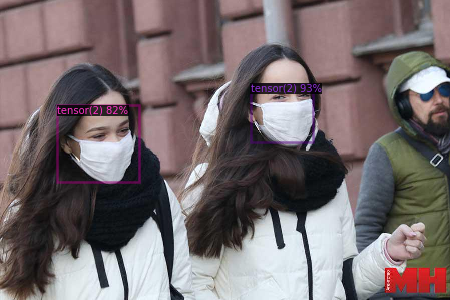

depositphotos_358544428-stock-photo-people-in-medical-protective-masks_jpg.rf.693feecd4d78976ee80a3786049ef959.jpg


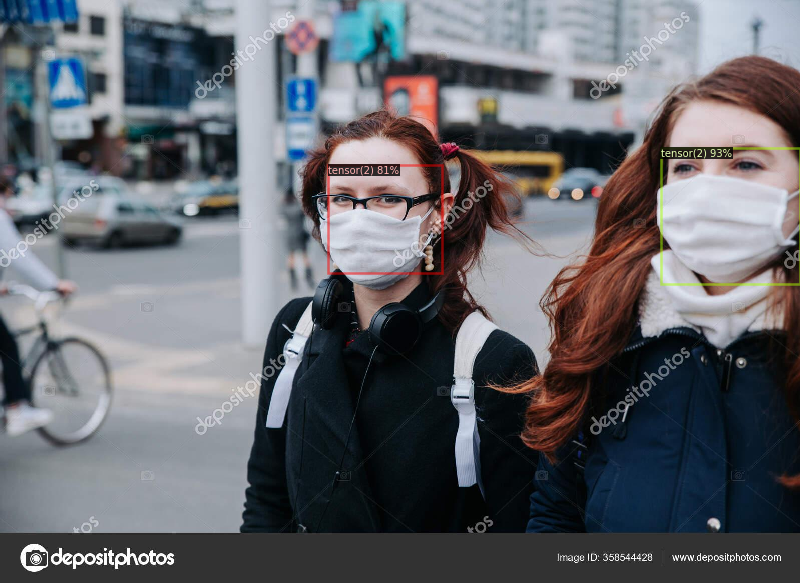

----_----_--------_jpg.rf.bc51342db972c36a6837e191ef4b49f2.jpg


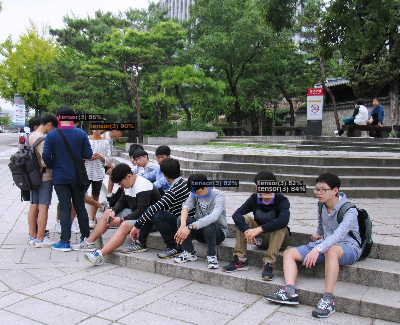

In [ ]:
from detectron2.utils.visualizer import ColorMode
import cv2

dataset_dicts = imgs_anns['images']

for d in random.sample(dataset_dicts, 3):  
    print(d['file_name'])  
    im = cv2.imread('/content/mask/valid/' + d['file_name'], cv2.IMREAD_COLOR )
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW 
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
